In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sns
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn, optim
from torch.utils.data import SubsetRandomSampler


In [22]:
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,56,48,44,98,98,99,63,59,60,43,...,31,31,37,56,60,69,56,63,75,1
1,74,78,69,91,88,83,198,206,157,102,...,185,198,201,169,178,181,116,120,122,1
2,6,9,9,3,6,6,8,11,10,6,...,49,68,65,55,74,71,39,55,54,1
3,156,165,169,161,172,176,149,160,164,163,...,114,121,124,125,131,136,137,142,145,1
4,75,71,73,16,48,34,166,141,116,67,...,38,47,59,59,87,90,84,106,118,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41245,14,6,6,14,6,7,11,5,6,11,...,7,2,57,10,4,66,10,1,79,0
41246,27,6,8,26,5,7,23,7,8,20,...,15,0,34,16,5,55,12,5,56,0
41247,3,3,3,3,3,3,3,3,3,3,...,71,31,14,85,46,28,71,42,25,0
41248,47,96,122,58,102,133,51,100,128,46,...,18,71,121,26,79,122,38,91,132,0


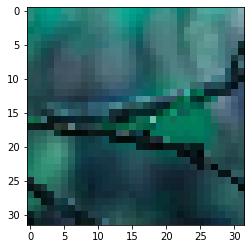

In [13]:
plt.imshow(np.array(data.iloc[500][0:3072]).reshape(32,32,3))

In [21]:
data['3072'].value_counts()

0    26750
1    14500
Name: 3072, dtype: int64

In [5]:
y = np.array(data['3072'])
X = np.array(data.drop('3072', axis = 1))

In [7]:
sns.histplot(y.count_values())

AttributeError: 'numpy.ndarray' object has no attribute 'count_values'

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.15, random_state = 42)

In [54]:
X_test

array([[ 66,  74,  88, ...,  32,  36,  40],
       [104, 148, 185, ..., 114, 163, 185],
       [  7,  12,  12, ...,  21,  39,  25],
       ...,
       [122, 132, 143, ...,  61,  63,  67],
       [169, 118,  52, ..., 110, 102, 108],
       [218, 221, 221, ..., 106, 108, 107]])

In [55]:
# prepare data to use with pytorch
class PathMNIST(Dataset):
    def __init__(self, mode="train", transform=None):

      if mode == "train":
        x, y = X_train, y_train
      elif mode == "val":
        x, y = X_val, y_val
      elif mode == "test":
        x, y = X_test, y_test
      else:
        raise ValueError("Invalid mode.")

  
      self._x = x
      self._y = y.squeeze()
      self._transform = transform

    def __len__(self):
      return self._x.shape[0]

    def __getitem__(self, idx):
      item = self._x[idx]
      label = self._y[idx]
      if self._transform is not None:
        item = self._transform(item)
      item = item.flatten()
      return item, label

In [56]:
train_set = PathMNIST(mode="train")
val_set = PathMNIST(mode="val")
test_set = PathMNIST(mode="test")


train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)
test_loader = DataLoader(test_set, batch_size=1)

In [57]:
train_set._x[0].shape

(3072,)

<AxesSubplot:ylabel='Count'>

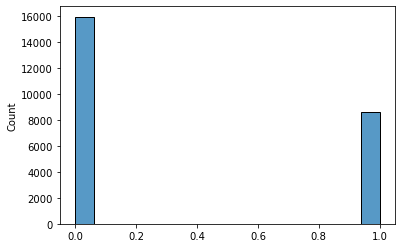

In [58]:
sns.histplot(train_set._y)

## Preparação para o pytorch

In [100]:
num_epochs = 500

In [101]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [102]:
def show_accuracy(pred_list, label_list):
  correct = [0,0]
  total = [0,0]
  matrix = np.zeros((2,2))

  for i in range(len(pred_list)):
    matrix[label_list[i]][pred_list[i]]+=1
    if pred_list[i] == label_list[i]:
      correct[pred_list[i]]+=1
    total[label_list[i]] += 1

  acc = [100*(x/y) for x,y in zip(correct,total)]
  print('Accuracy of the network on the 10004 val images on each class:')
  print(acc)
  print('Total accuracy:',100*(sum(correct)/sum(total)),"%")
  plt.figure(figsize=(15,15))
  sns.heatmap(matrix,annot = True,cmap="YlGnBu")
  plt.show()

## Rede Neural

In [103]:
#Criando a primeira rede:
class MinhaRede(nn.Module):
    #Rede com 7 hidden layers
  def __init__(self, tam_entrada):
    super(MinhaRede, self).__init__()

    # Definir a arquitetura
    self.rede = nn.Sequential(
        nn.Linear(tam_entrada, 512),
        nn.ReLU(),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,32),
        nn.ReLU(),
        nn.Linear(32,2),
        nn.ReLU(),
    )
  

  def forward(self, imagem):
    saida = self.rede(imagem)
    return saida

In [104]:
tam_entrada = 3 * 32 * 32
rede = MinhaRede(tam_entrada).to(device)

In [105]:
#inicializando os pesos com o metodo Xavier
def initialize_weights(m):
  if isinstance(m, nn.Linear):
      nn.init.xavier_uniform(m.weight)
      m.bias.data.fill_(0.01)

rede.apply(initialize_weights)

<ipython-input-105-4a47e4f753db>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


MinhaRede(
  (rede): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=32, bias=True)
    (15): ReLU()
    (16): Linear(in_features=32, out_features=2, bias=True)
    (17): ReLU()
  )
)

In [106]:
optimizer = optim.SGD(rede.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [107]:

def forward(mode, loader):

  if mode == 'train':
    rede.train()
  else:
    rede.eval()
  
  epoch_loss = []
  pred_list, label_list = [], []

  for data, label in loader:
    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    out = rede(data.float()/255)
    loss = criterion(out, label.long())
    epoch_loss.append(loss.cpu().data)

    predicted=out.data.max(dim=1)[1].cpu().numpy()
    pred_list.append(predicted)
    label_list.append(label.cpu().numpy())

    if mode == 'train':
      loss.backward()
      optimizer.step()
  
  epoch_loss = np.asarray(epoch_loss)
  pred_list = np.asarray(pred_list).ravel()
  label_list = np.asarray(label_list).ravel()
  if mode != 'train':
    return pred_list, label_list
  print(mode, 'Loss:', epoch_loss.mean(), '+/-', epoch_loss.std())

In [108]:
for i in range(num_epochs):
  print(i)
  forward('train', train_loader)

0
train Loss: 0.64662796 +/- 0.05176155
1
train Loss: 0.6454382 +/- 0.053424146
2
train Loss: 0.64204514 +/- 0.053467166
3
train Loss: 0.6408813 +/- 0.056705162
4
train Loss: 0.64018303 +/- 0.056910265
5
train Loss: 0.6373481 +/- 0.057408255
6
train Loss: 0.634653 +/- 0.057905618
7
train Loss: 0.6334015 +/- 0.056231692
8
train Loss: 0.6315825 +/- 0.061838187
9
train Loss: 0.6268617 +/- 0.06097757
10
train Loss: 0.62665653 +/- 0.06074806
11
train Loss: 0.62096554 +/- 0.06301421
12
train Loss: 0.6195242 +/- 0.062133867
13
train Loss: 0.6181164 +/- 0.06673021
14
train Loss: 0.61478466 +/- 0.06577131
15
train Loss: 0.608261 +/- 0.0629286
16
train Loss: 0.60951906 +/- 0.065454505
17
train Loss: 0.6091053 +/- 0.06488154
18
train Loss: 0.60268754 +/- 0.070384555
19
train Loss: 0.5962908 +/- 0.06856094
20
train Loss: 0.5950231 +/- 0.071902454
21
train Loss: 0.59283805 +/- 0.068369724
22
train Loss: 0.5851813 +/- 0.0730873
23
train Loss: 0.5797633 +/- 0.074125655
24
train Loss: 0.5778576 +/- 0.

train Loss: 0.06442625 +/- 0.061650407
199
train Loss: 0.06843557 +/- 0.06426072
200
train Loss: 0.06495204 +/- 0.06960041
201
train Loss: 0.06366481 +/- 0.06417128
202
train Loss: 0.06118522 +/- 0.061545044
203
train Loss: 0.05079221 +/- 0.05379717
204
train Loss: 0.05371791 +/- 0.053251993
205
train Loss: 0.061243687 +/- 0.06178201
206
train Loss: 0.052321333 +/- 0.05547969
207
train Loss: 0.054029536 +/- 0.057396952
208
train Loss: 0.04728136 +/- 0.04914176
209
train Loss: 0.05279459 +/- 0.055713747
210
train Loss: 0.061111394 +/- 0.06945551
211
train Loss: 0.054668337 +/- 0.055058043
212
train Loss: 0.046719804 +/- 0.05728971
213
train Loss: 0.04876924 +/- 0.052154206
214
train Loss: 0.052082904 +/- 0.058797188
215
train Loss: 0.052158598 +/- 0.059680555
216
train Loss: 0.053907968 +/- 0.05547433
217
train Loss: 0.04577399 +/- 0.050225534
218
train Loss: 0.048410706 +/- 0.051427126
219
train Loss: 0.0550667 +/- 0.05986585
220
train Loss: 0.047158256 +/- 0.060822
221
train Loss: 0.0

train Loss: 0.009205742 +/- 0.026474457
389
train Loss: 0.012029418 +/- 0.03340461
390
train Loss: 0.0109859975 +/- 0.034415588
391
train Loss: 0.010478803 +/- 0.032524616
392
train Loss: 0.0074208607 +/- 0.024730764
393
train Loss: 0.010724739 +/- 0.029809602
394
train Loss: 0.0132421935 +/- 0.03357469
395
train Loss: 0.016233087 +/- 0.040785667
396
train Loss: 0.011446644 +/- 0.034760863
397
train Loss: 0.010599957 +/- 0.031054571
398
train Loss: 0.004201626 +/- 0.020778254
399
train Loss: 0.019034347 +/- 0.041654136
400
train Loss: 0.014457268 +/- 0.03549321
401
train Loss: 0.0107447 +/- 0.029462349
402
train Loss: 0.011039318 +/- 0.028004304
403
train Loss: 0.012568248 +/- 0.032842867
404
train Loss: 0.014601736 +/- 0.03263771
405
train Loss: 0.007714606 +/- 0.027491555
406
train Loss: 0.011998587 +/- 0.038800303
407
train Loss: 0.007699991 +/- 0.020954529
408
train Loss: 0.0051675504 +/- 0.022997245
409
train Loss: 0.022503179 +/- 0.053649563
410
train Loss: 0.008646622 +/- 0.0240

In [109]:
print(device)

cpu


Accuracy of the network on the 10004 val images on each class:
[73.23643653677485, 34.34228493400091]
Total accuracy: 59.42626262626263 %


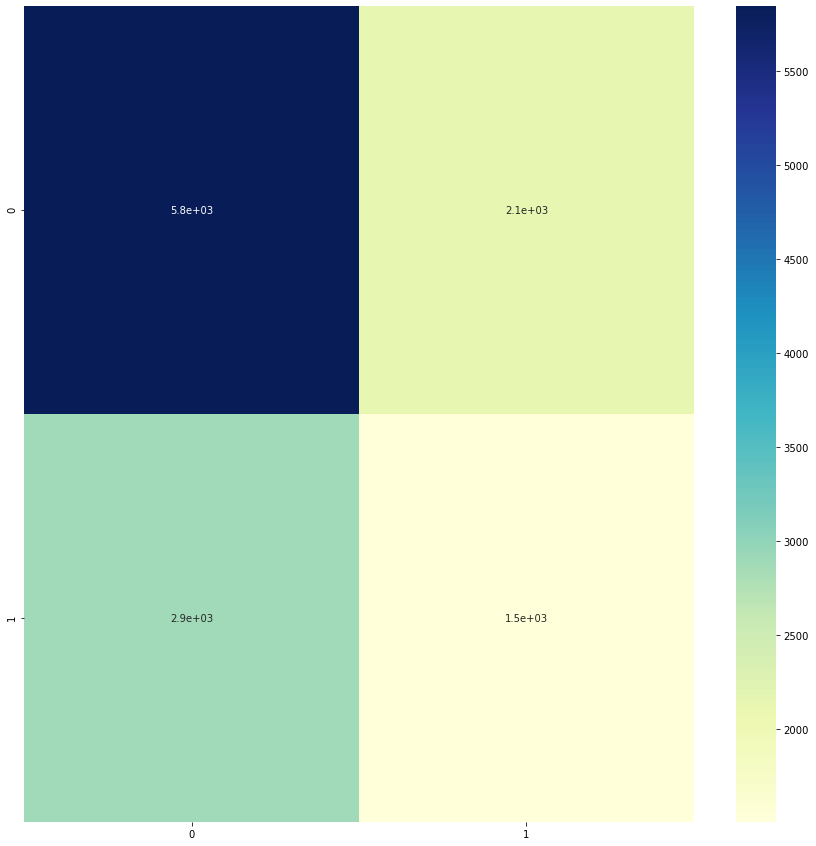

In [110]:
pred_list, label_list = forward('val', val_loader)
show_accuracy(pred_list, label_list)